# Introduction



Since Jan. 1, 2015, [*The Washington Post*](https://www.washingtonpost.com/) has maintained **Fatal Force**, a comprehensive record of every on-duty police shooting in the United States. To date, the database chronicles over **10,400** individual cases—each enriched with dozens of attributes, including:

- **Race**, **age**, and **gender** of the person killed  
- Whether the victim was **armed**  
- Whether the victim was in a **mental-health crisis**  
- The **agency** involved  

<center><img src="https://i.imgur.com/sX3K62b.png"></center>
<figcaption><small>Figure 1. Monthly counts of civilians shot and killed by on-duty U.S. police officers (Jan 2015–Dec 2024).</small></figcaption>

---

## Purpose of this Notebook: Fatal Force Data Wrangling

This notebook focuses on **cleaning and preparing the Fatal Force dataset** (2015–2024) so it can be reliably merged with external socioeconomic data (from the Census API). Key steps include:

1. **Import & Inspect** the raw Fatal Force data  
2. **Standardize columns** (date formats, city/state fields, categorical variables)  
3. **Handle missing values** and Census-coded nulls  
4. **Normalize identifiers** (e.g., FIPS GEOIDs, city/state keys)  
5. **Aggregate** fatalities at different levels (monthly, yearly, city, state)  
6. **Export** a clean dataset for downstream analysis and modeling  

By the end of this notebook, Fatal Force data will be **analysis-ready**, enabling integration with Census-derived indicators (income, poverty, education, race) in later notebooks.

**Data source:** Fatal Force (The Washington Post)
 

##  Environment Setup

- **Upgrade Plotly** (if needed, especially in Colab): `%pip install --upgrade plotly`  
- **Import libraries**: `numpy`, `pandas`, `plotly.express`, `matplotlib`, `seaborn`  
- **Optional utility**: `Counter` from `collections`  
- **Notebook display**: format floats with commas + 2 decimals for readability


In [3]:
%pip install --upgrade plotly

Note: you may need to restart the kernel to use updated packages.


## Import Statements

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# This might be helpful:
from collections import Counter

## Notebook Presentation

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

##  Load the Data

Import datasets produced from Census API and Fatal Force wrangling:

- `Median_Household_Income_2023.csv`  
- `Pct_People_Below_Poverty_Level_2023.csv`  
- `Pct_Completed_HS_2023.csv`  
- `Share_of_Race_By_City_2023.csv`  
- `Deaths_by_Police_US_15-2024.csv`  

These files form the foundation for merging socioeconomic indicators with police fatality data.


## 1. Data Wrangling 

##   Load the Data

In [7]:
df_hh_income = pd.read_csv('/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Median_Household_Income_2023.csv')
df_pct_poverty = pd.read_csv('/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Pct_People_Below_Poverty_Level_2023.csv')
df_pct_completed_hs = pd.read_csv('/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Pct_Completed_HS_2023.csv')
df_share_race_city = pd.read_csv('/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Share_of_Race_By_City_2023.csv')
df_fatalities = pd.read_csv('/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Deaths_by_Police_US 15-2024.csv',encoding="latin1")

##  Inspect the Data

Check the first few rows of each dataset to confirm successful load and understand column structure (schema).


In [8]:
df_hh_income.head()

Geographic Area             City  Median Income
0              AL       Abanda CDP            NaN
1              AL   Abbeville city      32,778.00
2              AL  Adamsville city      60,564.00
3              AL     Addison town      54,911.00
4              AL       Akron town      43,375.00

In [9]:
df_pct_poverty.head()

Geographic Area             City  poverty_rate
0              AL       Abanda CDP          0.00
1              AL   Abbeville city         22.00
2              AL  Adamsville city         18.80
3              AL     Addison town         11.70
4              AL       Akron town         10.70

In [10]:
df_pct_completed_hs.head()

Geographic Area             City  percent_completed_hs
0              AL       Abanda CDP                100.00
1              AL   Abbeville city                 80.30
2              AL  Adamsville city                 83.00
3              AL     Addison town                 83.90
4              AL       Akron town                 84.10

In [11]:
df_share_race_city.head()

Geographic Area             City  share_white  share_black  share_native  \
0              AL       Abanda CDP       100.00         0.00          0.00   
1              AL   Abbeville city        55.60        41.30          0.50   
2              AL  Adamsville city        40.50        56.70          0.00   
3              AL     Addison town        96.60         0.00          0.00   
4              AL       Akron town         5.40        85.90          0.00   

   share_asian  share_pacisl  share_other  share_two+  
0         0.00          0.00         0.00        0.00  
1         0.00          0.40         0.90        1.30  
2         2.60          0.00         0.00        0.30  
3         0.00          0.00         0.00        3.40  
4         0.00          0.00         0.00        8.80

In [12]:
df_pct_completed_hs.head()

Geographic Area             City  percent_completed_hs
0              AL       Abanda CDP                100.00
1              AL   Abbeville city                 80.30
2              AL  Adamsville city                 83.00
3              AL     Addison town                 83.90
4              AL       Akron town                 84.10

In [13]:
df_fatalities.head()

date                name   age gender    armed      race     city state  \
0  1/2/15    Lewis Lee Lembke 47.00   male      gun     White    Aloha    OR   
1  1/2/15          Tim Elliot 53.00   male      gun     Asian  Shelton    WA   
2  1/3/15  John Paul Quintero 23.00   male  unarmed  Hispanic  Wichita    KS   
3  1/4/15   Kenneth Joe Brown 18.00   male      gun     White  Guthrie    OK   
4  1/4/15   Michael Rodriguez 39.00   male    other  Hispanic    Evans    CO   

  flee  body_camera  signs_of_mental_illness  \
0  not        False                    False   
1  not        False                     True   
2  not        False                    False   
3  not        False                    False   
4  not        False                    False   

              police_departments_involved  
0  Washington County Sheriff's Office, OR  
1       Mason County Sheriff's Office, WA  
2           Wichita Police Department, KS  
3             Oklahoma Highway Patrol, OK  
4             Evans Police Department, CO

 ---

###  1.2 Preliminary Data Exploration  

In this step, we examine each dataset to understand its basic structure and data quality.  

- ✅ **Shape** – How many rows and columns are in each table?  
- ✅ **Column Names** – What are the available fields?  
- ✅ **Missing Values** – Are there any NaNs per column?  
- ✅ **Duplicate Rows** – Are there duplicate entries?  




In [14]:
# ── Preliminary Data Exploration ──

tables = {
    "Household Income":    df_hh_income,
    "Poverty Rate":        df_pct_poverty,
    "HS Completion %":     df_pct_completed_hs,
    "Race Shares":         df_share_race_city,
    "Fatal Shootings":     df_fatalities
}

for name, tbl in tables.items():
    rows, cols = tbl.shape
    print(f"\n## {name}")
    # 1) Shape
    print(f"- Shape: {rows} rows × {cols} columns")
    # 2) Column names
    print(f"- Columns: {list(tbl.columns)}")
    # 3) Missing values
    nulls = tbl.isna().sum()
    missing = nulls[nulls > 0]
    if missing.empty:
        print("- Missing values: None")
    else:
        print("- Missing values (per column):")
        for col, cnt in missing.items():
            print(f"    - `{col}`: {cnt}")
    # 4) Duplicate rows
    print(f"- Duplicate rows: {tbl.duplicated().sum()}")





## Household Income
- Shape: 32325 rows × 3 columns
- Columns: ['Geographic Area', 'City', 'Median Income']
- Missing values (per column):
    - `Geographic Area`: 292
    - `Median Income`: 3750
- Duplicate rows: 0

## Poverty Rate
- Shape: 32325 rows × 3 columns
- Columns: ['Geographic Area', 'City', 'poverty_rate']
- Missing values (per column):
    - `Geographic Area`: 292
    - `poverty_rate`: 514
- Duplicate rows: 0

## HS Completion %
- Shape: 32325 rows × 3 columns
- Columns: ['Geographic Area', 'City', 'percent_completed_hs']
- Missing values (per column):
    - `Geographic Area`: 292
    - `percent_completed_hs`: 500
- Duplicate rows: 0

## Race Shares
- Shape: 32325 rows × 9 columns
- Columns: ['Geographic Area', 'City', 'share_white', 'share_black', 'share_native', 'share_asian', 'share_pacisl', 'share_other', 'share_two+']
- Missing values (per column):
    - `Geographic Area`: 292
    - `share_white`: 478
    - `share_black`: 478
    - `share_native`: 478
    - `share_as

### 1.3  Data Cleaning – Handling Missing Values & Duplicates  

After identifying data issues, we perform the following cleaning steps:  

1. **Remove Duplicates** – Drop exact duplicate rows across all Census tables.  
2. **Handle Missing Values**  
   - Replace missing values in Census percentages/shares with `0`.  
   - Fill missing *Median Income*, *Poverty Rate*, and *HS Completion %* with `0`.  
   - For racial share columns, fill missing values with `0`.  
3. **Drop Invalid Records** – Remove rows in the Fatalities table with missing `city` or `state`.  
4. **Verify Cleanup** – Re-check all tables to confirm there are no missing values or duplicates left.  

This ensures clean, consistent data before integration and analysis.  


In [15]:
# ── Data Cleaning: Handle Missing Values & Duplicates ──

# 1) Drop any exact duplicate rows in all tables
for tbl in (df_hh_income, df_pct_poverty, df_pct_completed_hs, df_share_race_city, df_fatalities):
    tbl.drop_duplicates(inplace=True)

# 2) Substitute 0 for missing census percentages/shares
df_hh_income['Median Income']               = df_hh_income['Median Income'].fillna(0)
df_pct_poverty['poverty_rate']               = df_pct_poverty['poverty_rate'].fillna(0)
df_pct_completed_hs['percent_completed_hs'] = df_pct_completed_hs['percent_completed_hs'].fillna(0)

share_cols = [c for c in df_share_race_city.columns if c.startswith('share_')]
df_share_race_city[share_cols]               = df_share_race_city[share_cols].fillna(0)

# 3) For the fatalities table, drop any rows where we can’t join (missing city/state)
df_fatalities.dropna(subset=['city','state'], inplace=True)

# 4) Verify there are now no missing values in the Census tables and no duplicates anywhere
tables = {
    "HH Income":    df_hh_income,
    "Poverty":      df_pct_poverty,
    "HS Comp %":    df_pct_completed_hs,
    "Race Shares":  df_share_race_city,
    "Fatalities":   df_fatalities
}

for name, tbl in tables.items():
    total_missing = tbl.isna().sum().sum()
    total_dupes  = tbl.duplicated().sum()
    print(f"{name:12} → Missing: {total_missing:3d}, Duplicates: {total_dupes:3d}")


HH Income    → Missing: 292, Duplicates:   0
Poverty      → Missing: 292, Duplicates:   0
HS Comp %    → Missing: 292, Duplicates:   0
Race Shares  → Missing: 292, Duplicates:   0
Fatalities   → Missing: 2369, Duplicates:   0


## 2. Exploratory Data Analysis (EDA)



We compute and visualize the **average poverty rate** across U.S. states (city-level rates aggregated to state-level).  

**Guiding Questions**  
- Which state has the **highest poverty rate**?  
- Which state has the **lowest poverty rate**?  

**Visualization:** Horizontal bar chart (ranked from highest to lowest).



### 2.1 Poverty Rate by State
Create a bar chart that ranks the poverty rate from highest to lowest by US state. Which state has the highest poverty rate? Which state has the lowest poverty rate?  Bar Plot

In [16]:
# ── 1) Compute state‐level poverty rate ──
# We’ll average the city‐level poverty_rate for each state
state_poverty = (
    df_pct_poverty
      .groupby('Geographic Area', as_index=False)['poverty_rate']
      .mean()
      .rename(columns={'Geographic Area':'state',
                       'poverty_rate':'avg_poverty_rate'})
      .sort_values('avg_poverty_rate', ascending=False)
)

state_poverty.head()


state  avg_poverty_rate
25    MS             23.23
18    LA             22.66
40    SC             20.07
3     AZ             19.88
32    NM             19.59

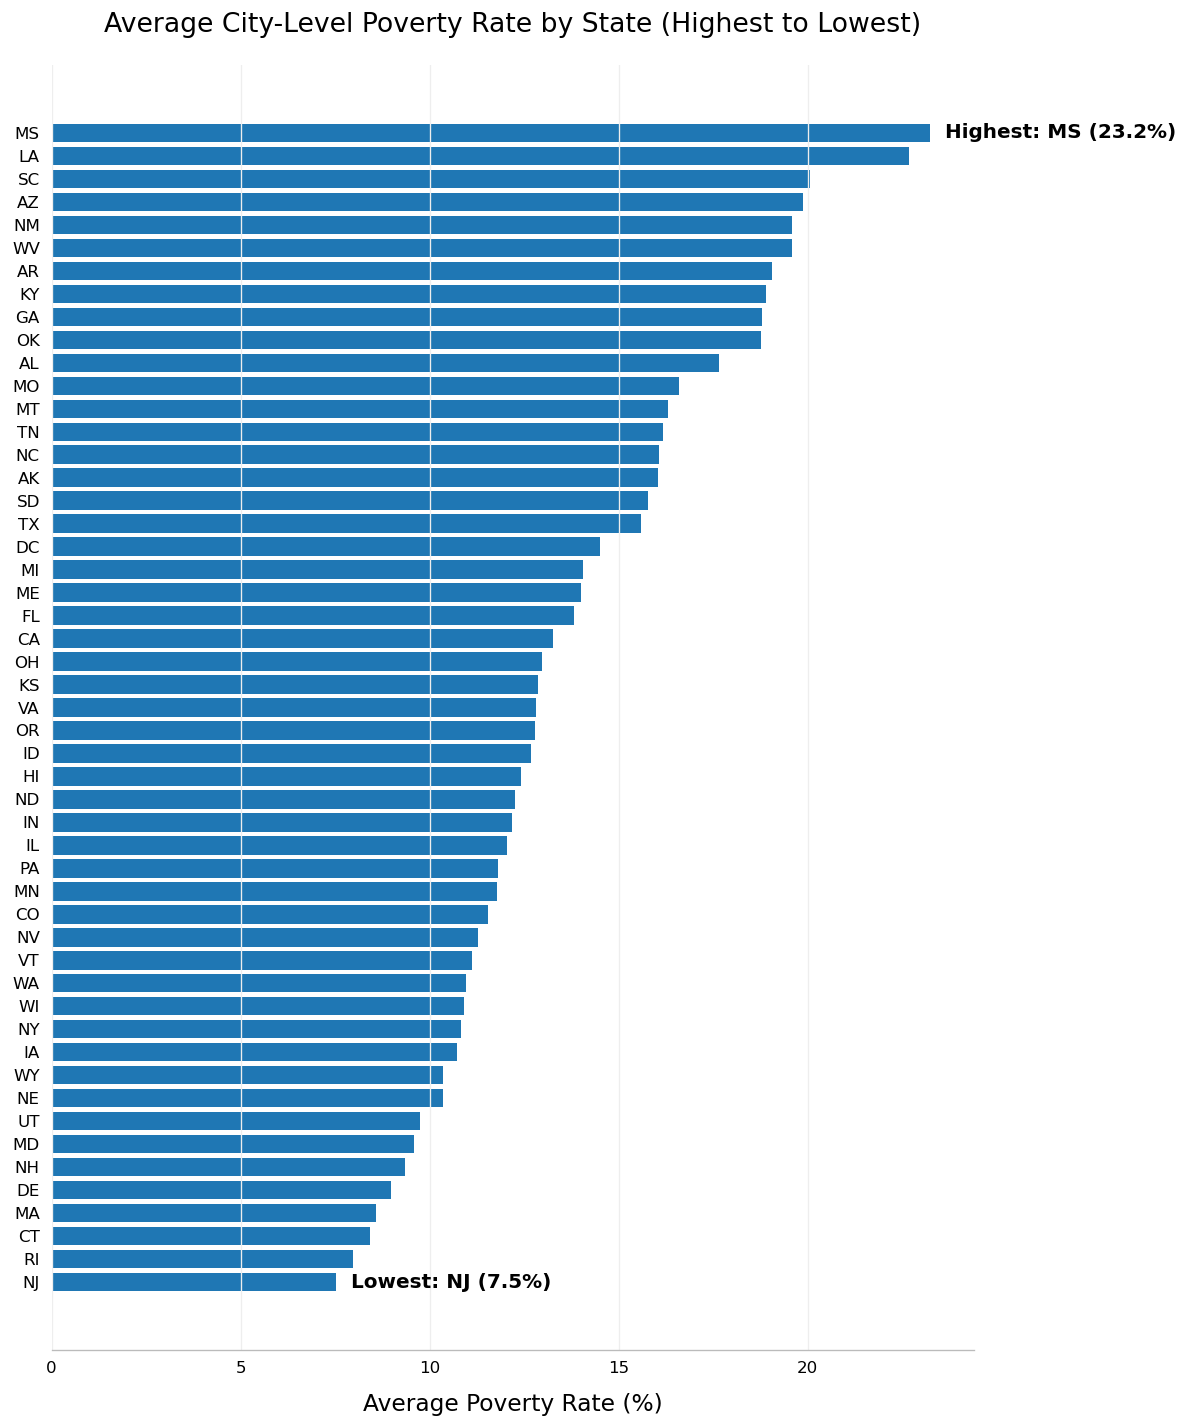

In [17]:
import matplotlib.pyplot as plt

# assume state_poverty is sorted descending with cols ['state','avg_poverty_rate']

blue = '#1f77b4'
fig, ax = plt.subplots(figsize=(10, 12), dpi=120)

ax.barh(
    state_poverty['state'],
    state_poverty['avg_poverty_rate'],
    color=blue,
    edgecolor='none'
)

ax.invert_yaxis()

# annotate highest & lowest
top = state_poverty.iloc[0]
bot = state_poverty.iloc[-1]
ax.text(
    top['avg_poverty_rate'] + 0.4, 0,
    f"Highest: {top['state']} ({top['avg_poverty_rate']:.1f}%)",
    va='center', fontsize=12, fontweight='bold'
)
ax.text(
    bot['avg_poverty_rate'] + 0.4, len(state_poverty)-1,
    f"Lowest: {bot['state']} ({bot['avg_poverty_rate']:.1f}%)",
    va='center', fontsize=12, fontweight='bold'
)

# styling
ax.set_title("Average City-Level Poverty Rate by State (Highest to Lowest)",
             pad=20, fontsize=16)
ax.set_xlabel("Average Poverty Rate (%)", labelpad=10, fontsize=14)
ax.set_ylabel("")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#bbbbbb')
ax.grid(axis='x', color='#eeeeee')

plt.tight_layout()
plt.show()




### 2.2 High School Graduation Rate by State

We compute and visualize the **average high school graduation rate** across U.S. states (aggregated from city-level data).

**Guiding Questions**  
- Which state has the **lowest graduation rate**?  
- Which state has the **highest graduation rate**?  

**Visualization:** Horizontal bar chart (ranked in ascending order).



In [18]:
# ── 1) Compute state‐level average HS graduation rate ──
state_hs = (
    df_pct_completed_hs
      .groupby('Geographic Area', as_index=False)['percent_completed_hs']
      .mean()
      .rename(columns={
          'Geographic Area':'state',
          'percent_completed_hs':'avg_hs_rate'
      })
      .sort_values('avg_hs_rate', ascending=True)
)
state_hs.head()


state  avg_hs_rate
43    TX        78.28
41    SD        79.33
32    NM        80.14
3     AZ        80.82
25    MS        81.51

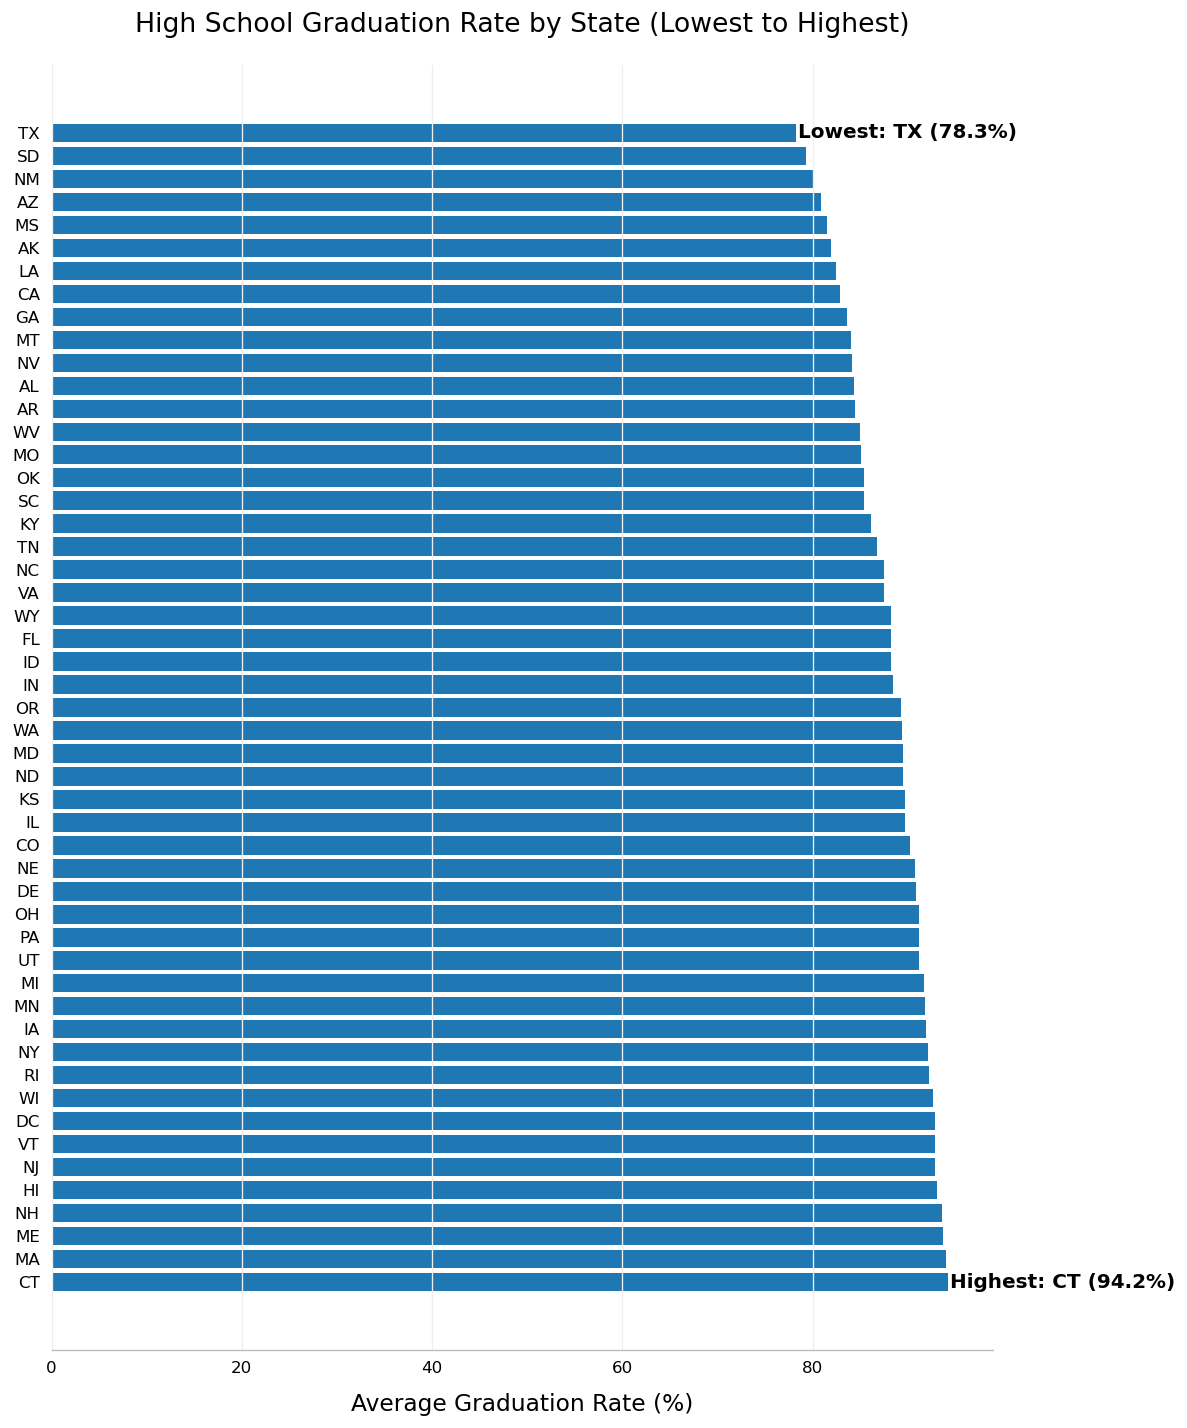

In [19]:
# ── 2) Horizontal bar chart (lowest → highest) ──
import matplotlib.pyplot as plt

blue = '#1f77b4'
fig, ax = plt.subplots(figsize=(10, 12), dpi=120)

ax.barh(
    state_hs['state'],
    state_hs['avg_hs_rate'],
    color=blue,
    edgecolor='none'
)
ax.invert_yaxis()

# annotate lowest & highest
low = state_hs.iloc[0]
high = state_hs.iloc[-1]
ax.text(
    low['avg_hs_rate'] + 0.2, 0,
    f"Lowest: {low['state']} ({low['avg_hs_rate']:.1f}%)",
    va='center', fontsize=12, fontweight='bold'
)
ax.text(
    high['avg_hs_rate'] + 0.2, len(state_hs)-1,
    f"Highest: {high['state']} ({high['avg_hs_rate']:.1f}%)",
    va='center', fontsize=12, fontweight='bold'
)

# clean style
ax.set_title("High School Graduation Rate by State (Lowest to Highest)", pad=20, fontsize=16)
ax.set_xlabel("Average Graduation Rate (%)", labelpad=10, fontsize=14)
ax.set_ylabel("")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
for spine in ('top','right','left'):
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color('#bbbbbb')
ax.grid(axis='x', color='#eeeeee')

plt.tight_layout()
plt.show()


### 2.3 Poverty Rate vs. High School Graduation Rate

We visualize the relationship between **poverty rates** and **high school graduation rates** to see whether these measures move together.

**Guiding Questions**  
- Do higher poverty rates correspond to lower graduation rates?  
- Is there evidence of an inverse relationship across states?  

**Visualization:** Dual-axis line chart (poverty rate on one y-axis, graduation rate on the other).


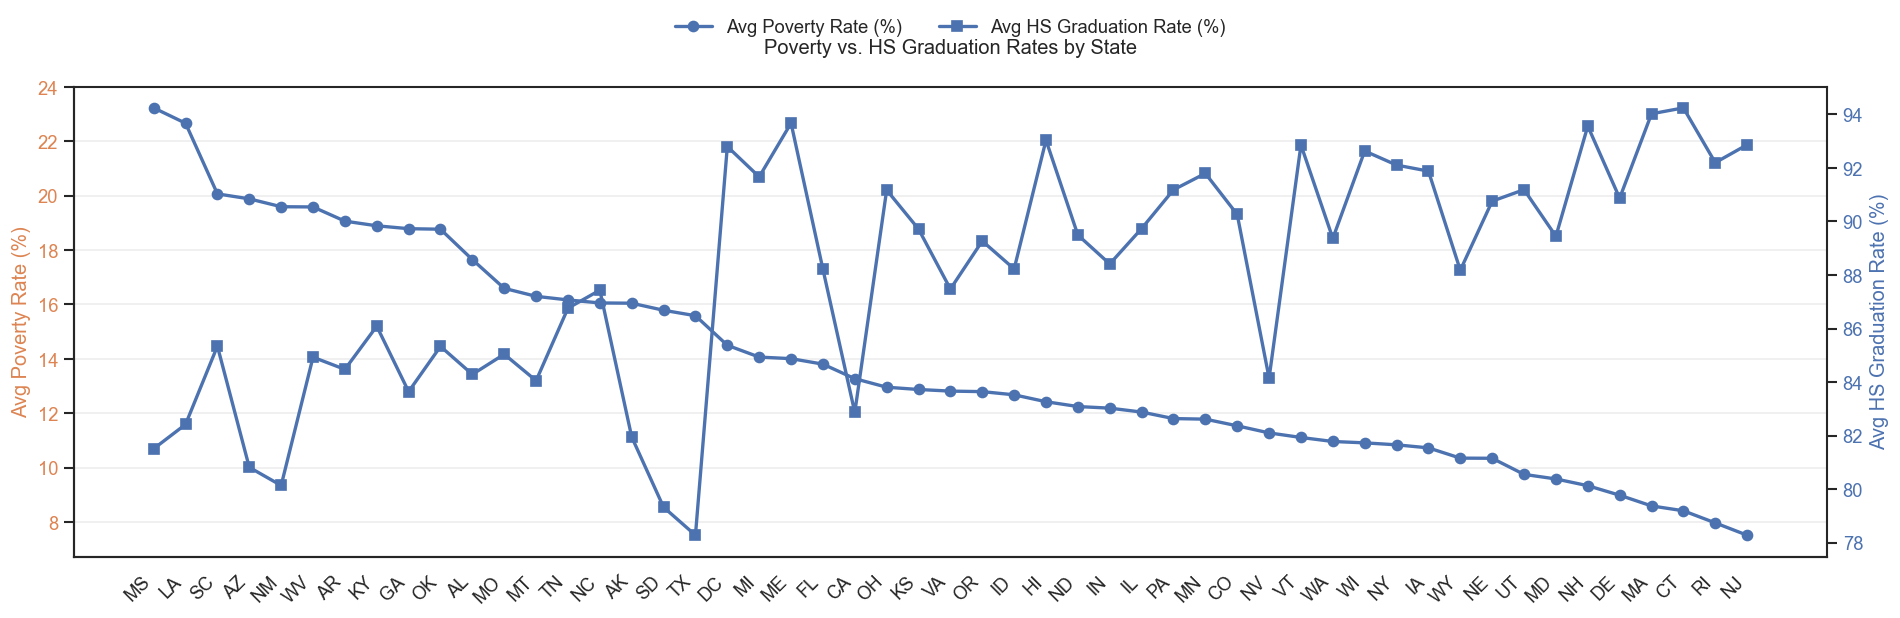

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

combo = state_poverty.merge(state_hs, on='state')

# — 3. Plot poverty vs HS graduation rates by state —
fig, ax1 = plt.subplots(figsize=(16, 6), dpi=120)

x  = combo['state']
y1 = combo['avg_poverty_rate']
y2 = combo['avg_hs_rate']

# Plot poverty rate
ln1 = ax1.plot(x, y1, marker='o', linewidth=2, label='Avg Poverty Rate (%)')
ax1.set_ylabel('Avg Poverty Rate (%)', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

# Rotate and align x-labels
ax1.set_xticks(range(len(x)))
ax1.set_xticklabels(x, rotation=45, ha='right')

# Create twin axis for HS graduation rate
ax2 = ax1.twinx()
ln2 = ax2.plot(x, y2, marker='s', linewidth=2, label='Avg HS Graduation Rate (%)')
ax2.set_ylabel('Avg HS Graduation Rate (%)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

# Title and combined legend
ax1.set_title('Poverty vs. HS Graduation Rates by State', pad=20)
lines  = ln1 + ln2
labels = [l.get_label() for l in lines]
fig.legend(lines, labels, loc='upper center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

# Tidy up spines and grid
for spine in ('top', 'right'):
    ax1.spines[spine].set_visible(False)
ax1.grid(axis='y', color='#EEEEEE')

# Layout adjustments
fig.tight_layout()
fig.subplots_adjust(bottom=0.25)

plt.show()



### 2.3.1 Joint Scatterplot of Poverty vs. HS Graduation Rates

We extend the previous analysis with a **Seaborn `jointplot()`**, which shows both:

* A **scatterplot** of average poverty rate vs. high school graduation rate.  
* **Marginal histograms** (or KDE, if enabled) along the axes to visualize the distribution of each variable.  

**Why this is useful:**  
- Helps identify whether higher poverty rates are associated with lower graduation rates.  
- Provides distributional context for both variables.  

**Visualization:** Scatterplot with marginal histograms.


### 2.3.2 Filled KDE Jointplot of Poverty vs. HS Graduation Rates

To better capture the overall distribution, we use a **Kernel Density Estimate (KDE) jointplot** with filled contours.

* ✅ **X-axis:** Average poverty rate by state  
* ✅ **Y-axis:** Average high school graduation rate by state  
* ✅ **Color Map (Blues):** Denser regions are shaded darker  

**Why this is useful:**  
- Shows whether clusters of states share similar poverty and graduation rates.  
- Highlights the joint density of the two measures rather than just individual points.  
- Provides smoother patterns that may indicate underlying trends.  

**Visualization:** KDE jointplot with filled contours (`cmap="Blues"`).  


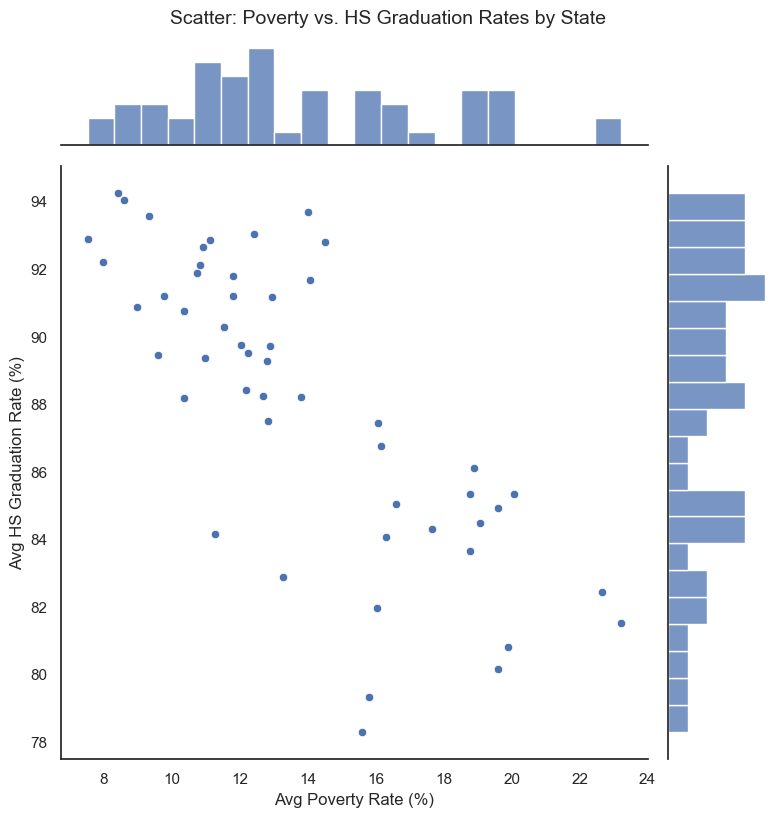

In [26]:
# ── Joint scatterplot of Poverty vs. HS Graduation Rates ──
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

jp_scatter = sns.jointplot(
    data=combo,
    x="avg_poverty_rate",
    y="avg_hs_rate",
    kind="scatter",
    height=8,
    marginal_kws=dict(bins=20, fill=True)
)

jp_scatter.set_axis_labels("Avg Poverty Rate (%)", "Avg HS Graduation Rate (%)")
plt.suptitle("Scatter: Poverty vs. HS Graduation Rates by State", y=1.02, fontsize=14)
plt.show()


### 2.3.3 Regression Jointplot of Poverty vs. HS Graduation Rates

To examine whether there is a **linear relationship** between poverty rates and high school graduation rates, we add a **regression line** on top of the scatter plot.

* ✅ **X-axis:** Average poverty rate by state  
* ✅ **Y-axis:** Average high school graduation rate by state  
* ✅ **Regression Line (red):** Fits a best‐fit line through the data points  

**Why this is useful:**  
- Quantifies whether states with higher poverty tend to have lower graduation rates.  
- Shows the **direction** (positive/negative) and **strength** (tightness around the line) of the relationship.  
- Complements the scatter and KDE plots by explicitly testing linear correlation.  

**Visualization:** Scatterplot with regression line (`kind="reg"`).  


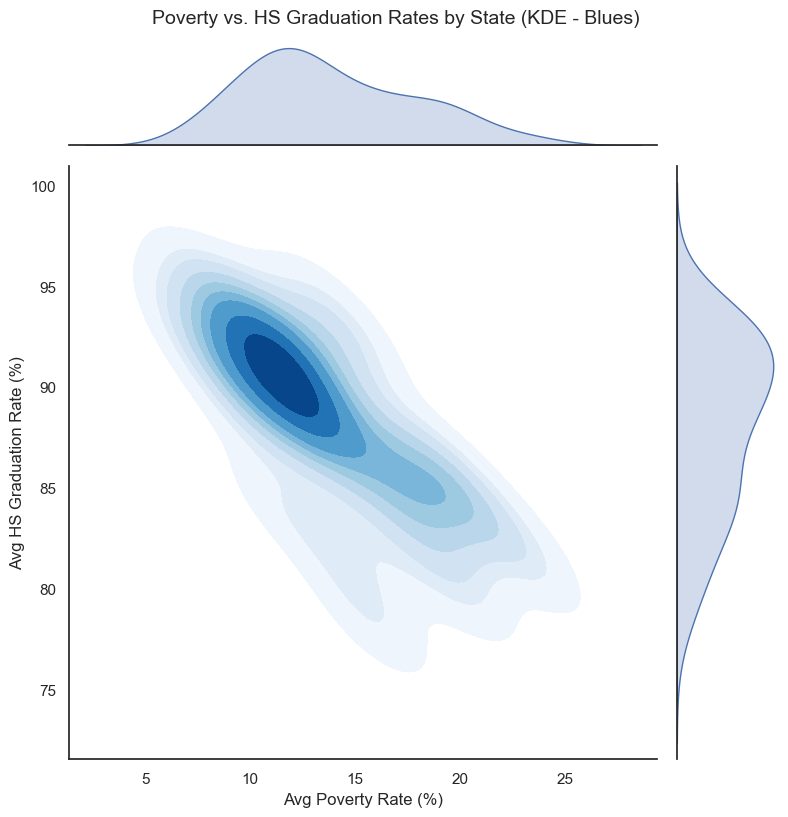

In [27]:
# ── Filled‐KDE jointplot with a blue cmap ──
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

sns.jointplot(
    data=combo,
    x="avg_poverty_rate",
    y="avg_hs_rate",
    kind="kde",
    fill=True,
    thresh=0.05,
    cmap="Blues",
    levels=10,
    height=8
).set_axis_labels("Avg Poverty Rate (%)", "Avg HS Graduation Rate (%)")

plt.suptitle("Poverty vs. HS Graduation Rates by State (KDE - Blues)", y=1.02, fontsize=14)
plt.show()



### 2.3.4 Linear Regression Plot: Poverty vs. HS Graduation Rates

In this step, we use a **regression plot** to fit a straight line through the scatterplot of poverty vs. high school graduation rates.

* ✅ **X-axis:** Average poverty rate (%)  
* ✅ **Y-axis:** Average high school graduation rate (%)  
* ✅ **Blue Points:** Each state’s poverty vs. graduation rate  
* ✅ **Orange Regression Line:** Best-fit linear relationship with 95% confidence band  

**Why this matters:**  
- Reveals whether a **negative linear trend** exists (i.e., higher poverty → lower graduation).  
- The slope of the regression line gives insight into the **strength and direction** of the association.  
- Confidence interval shading shows the uncertainty around the line.  

**Visualization:** Scatterplot + regression line (`sns.regplot`).  


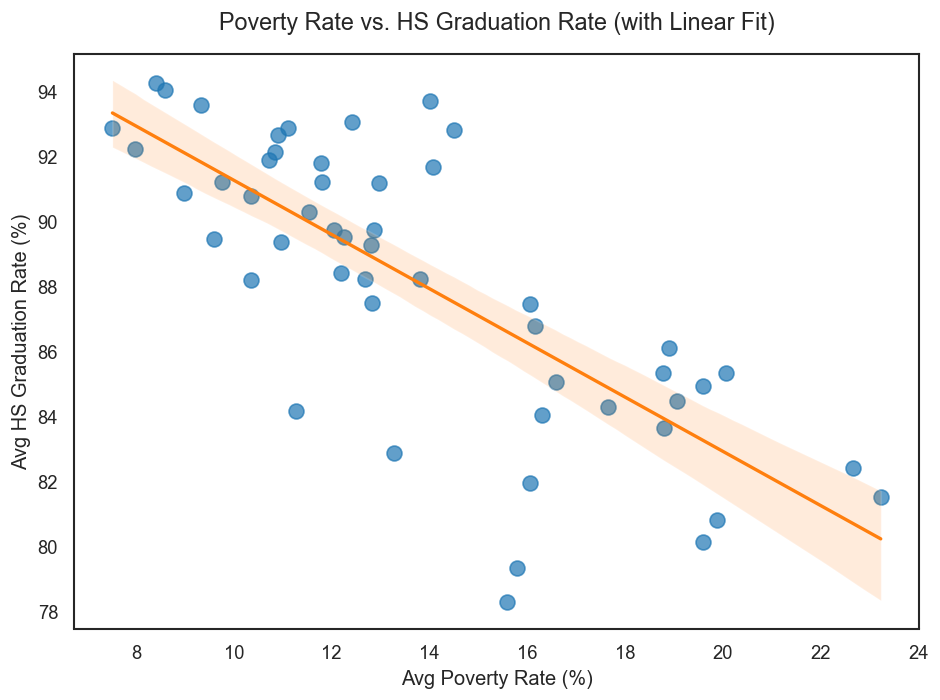

In [28]:
# ── Linear Regression: Poverty vs. HS Graduation Rate ──
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=120)

sns.regplot(
    data=combo,
    x='avg_poverty_rate',
    y='avg_hs_rate',
    scatter_kws={'s': 80, 'color': '#1f77b4', 'alpha': 0.7},
    line_kws={'color': '#ff7f0e', 'linewidth': 2},
    ci=95
)

plt.title('Poverty Rate vs. HS Graduation Rate (with Linear Fit)', pad=15, fontsize=14)
plt.xlabel('Avg Poverty Rate (%)', fontsize=12)
plt.ylabel('Avg HS Graduation Rate (%)', fontsize=12)
plt.tight_layout()
plt.show()


### 2.3.5 Bar Chart with Subsections: Racial Makeup of Each U.S. State

In this step, we visualize the **racial composition** of U.S. states using a grouped bar chart.  
The following groups are included:

- **White population share (`share_white`)**  
- **Black population share (`share_black`)**  
- **Hispanic population share (`share_hispanic`)**  
- **Asian population share (`share_asian`)**  
- **Native American population share (`share_native`)**  

**Steps performed:**
1. ✅ Renamed columns for clarity (e.g., `Geographic Area → state`).  
2. ✅ Selected the five race-share columns of interest.  
3. ✅ Grouped data at the **state level** and calculated the **mean share** across cities.  
4. ✅ Sorted states alphabetically for easier comparison.  

**Why this matters:**  
- Helps us understand the **demographic diversity** across states.  
- Provides a baseline for later analysis of how **racial composition relates to socioeconomic outcomes and fatalities**.  

**Visualization type:** Grouped Bar Chart with subsections by race.  


In [29]:
# ── 1) Compute state‐level average race shares ──

# First, rename for clarity and select the five races of interest
df_state_race = (
    df_share_race_city
      .rename(columns={
          'Geographic Area':'state',
          'share_other':'share_hispanic'
      })
      .loc[:, ['state',
               'share_white',
               'share_black',
               'share_hispanic',
               'share_asian',
               'share_native']]
)

# Group by state and take the mean of each share
state_race = (
    df_state_race
      .groupby('state', as_index=True)
      .mean()
      .sort_index()
)

state_race.head(10)


share_white  share_black  share_hispanic  share_asian  share_native
state                                                                     
AK           38.88         0.79            0.95         2.02         41.62
AL           69.10        23.25            1.82         0.67          0.34
AR           73.90        14.85            1.71         0.64          0.46
AZ           52.39         0.87            4.56         0.88         25.82
CA           59.03         2.44           13.35         6.63          1.64
CO           78.97         1.00            4.08         1.31          1.52
CT           81.02         4.32            3.19         3.51          0.50
DC           39.10        43.30            4.80         4.10          0.30
DE           66.72        17.93            3.34         2.61          0.35
FL           68.27        12.48            4.68         1.92          0.42

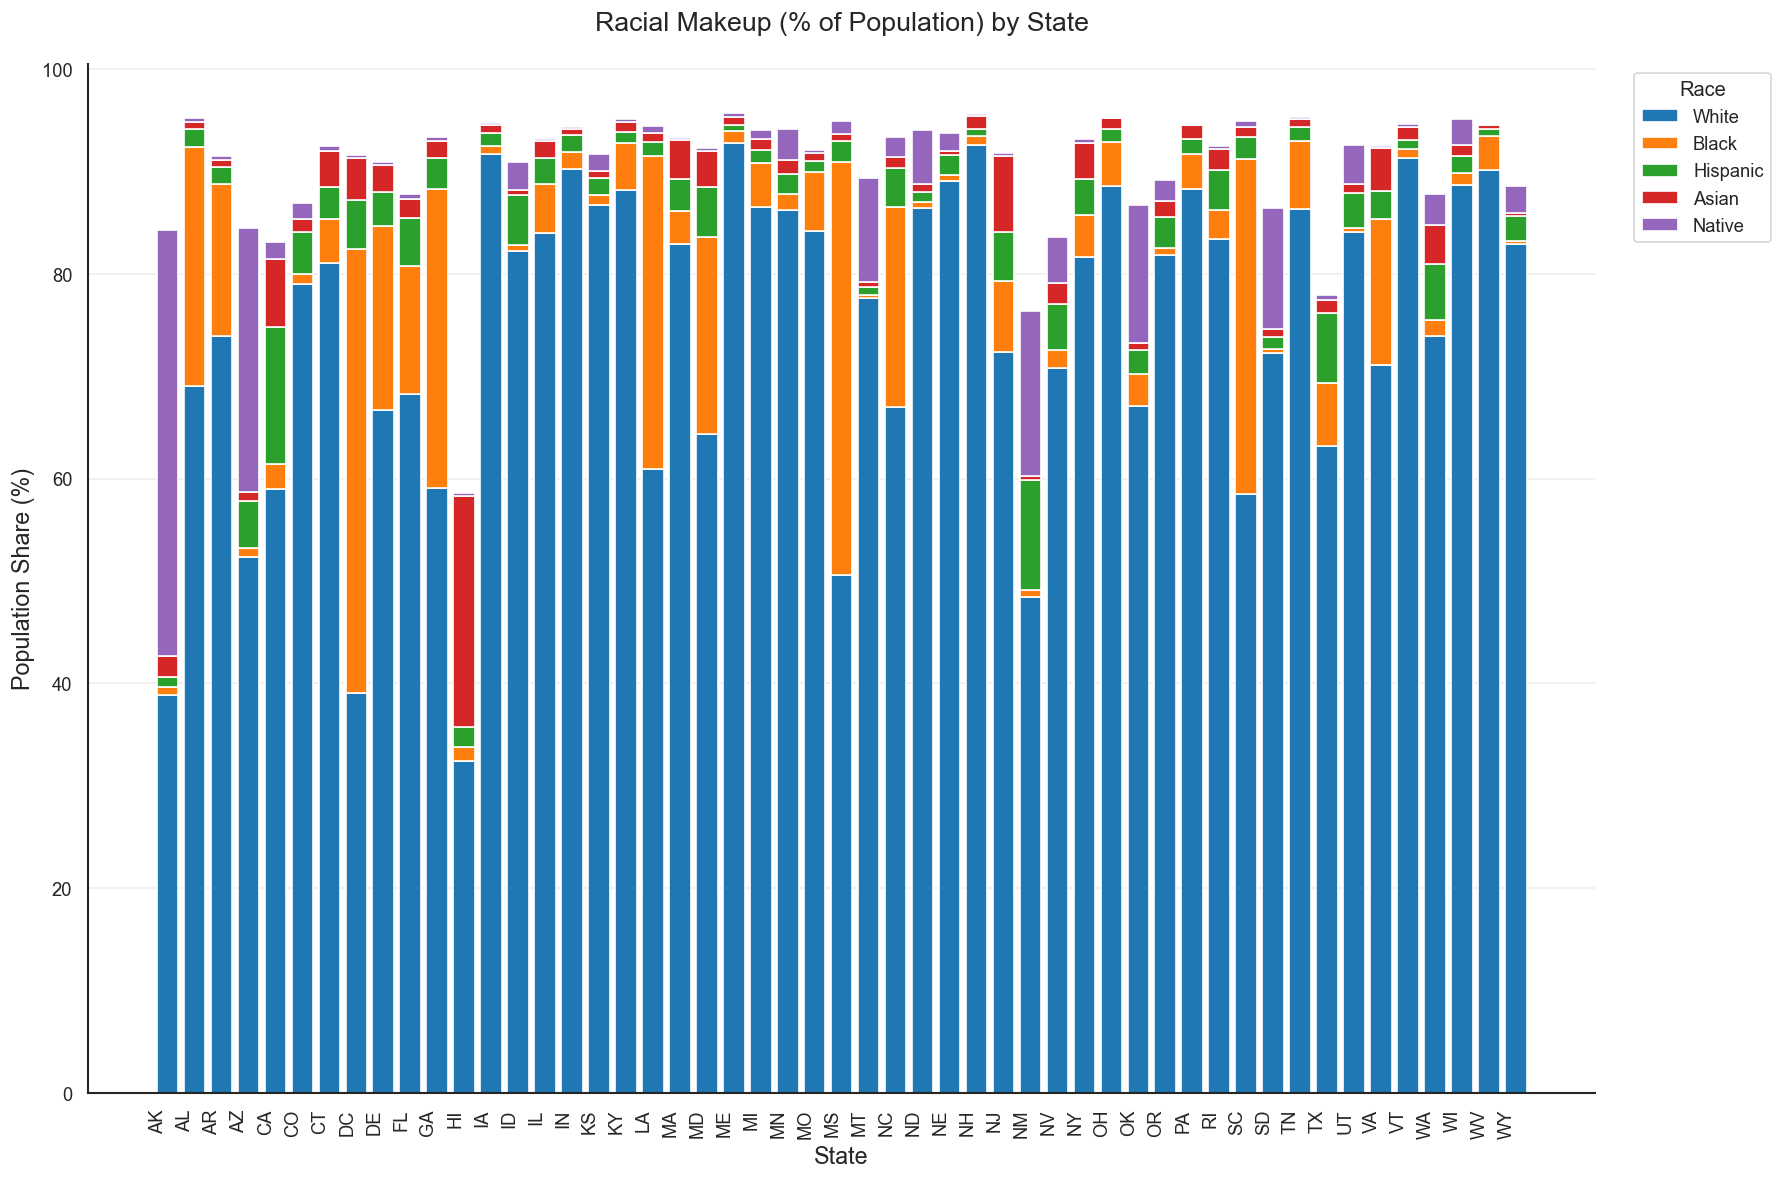

In [30]:
# ── 2) Stacked bar chart of racial makeup by state ──

import matplotlib.pyplot as plt
import numpy as np

# Define colors for each race
colors = {
    'share_white':    '#1f77b4',
    'share_black':    '#ff7f0e',
    'share_hispanic': '#2ca02c',
    'share_asian':    '#d62728',
    'share_native':   '#9467bd',
}

fig, ax = plt.subplots(figsize=(15, 10), dpi=120)

# Plot each race as a stacked bar
bottom = np.zeros(len(state_race))
for race, col in state_race.items():
    ax.bar(
        state_race.index,
        col.values,
        bottom=bottom,
        label=race.split('_')[1].title(),
        color=colors[race]
    )
    bottom += col.values

# Styling
ax.set_title("Racial Makeup (% of Population) by State", pad=20, fontsize=16)
ax.set_ylabel("Population Share (%)", fontsize=14)
ax.set_xlabel("State", fontsize=14)
ax.set_xticks(range(len(state_race.index)))
ax.set_xticklabels(state_race.index, rotation=90, ha='right')
ax.legend(title="Race", bbox_to_anchor=(1.02, 1), loc='upper left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', color='#eeeeee')

plt.tight_layout()
plt.show()


### 2.5 Donut Chart of People Killed by Race

We now examine the racial distribution of people killed by police.  

**Steps performed:**
1. ✅ Extracted the `race` column from the fatalities dataset.  
2. ✅ Replaced missing values with `"Unknown"`.  
3. ✅ Used `.value_counts()` to compute the number of deaths by race.  
4. ✅ Converted results into a clean DataFrame with columns: `race` and `count`.  

**Why a Donut Chart?**
- A **donut chart** is a variation of a pie chart that allows us to highlight proportions more clearly while leaving space in the middle for annotations.  
- This makes it easier to compare the **relative burden** of fatalities across racial groups.  

**Visualization type:** Donut Chart  


In [31]:
# ── 1) Count fatalities by race ──
race_counts = df_fatalities['race'] \
    .fillna('Unknown') \
    .value_counts() \
    .rename_axis('race') \
    .reset_index(name='count')
race_counts


race  count
0                         White   4618
1                         Black   2479
2                      Hispanic   1711
3                       Unknown   1168
4                         Asian    184
5               Native American    146
6                         Other     37
7                   White,Black      4
8                White,Hispanic      3
9                Black,Hispanic      3
10  White,Black,Native American      1
11     Native American,Hispanic      1
12                  White,Asian      1

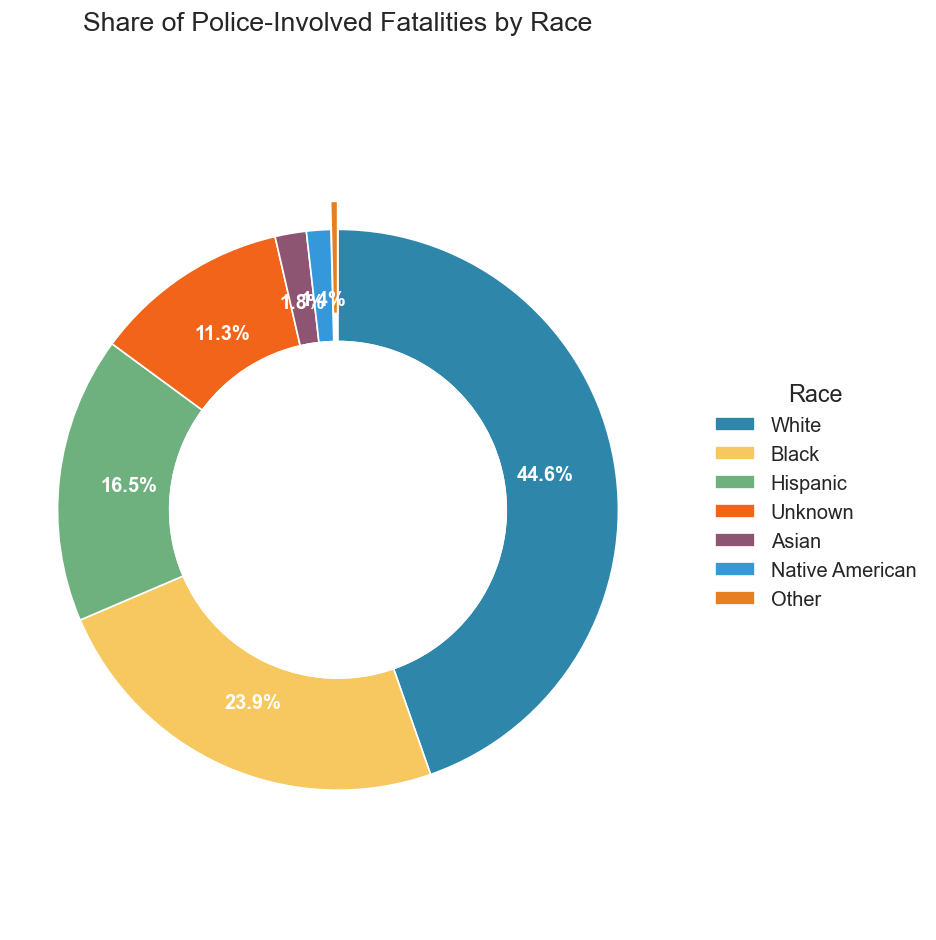

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Get counts & percentages
raw    = df_fatalities['race'].fillna('Unknown').value_counts()
total  = raw.sum()
pct    = (raw / total * 100).round(1)

# 2) Major (≥1%) vs. lumped “Other”
major    = pct[pct >= 1]
minor    = pct[pct <  1].sum()
data     = pd.concat([major, pd.Series({'Other': minor})])
labels   = data.index.tolist()
sizes    = data.values.tolist()

# 3) Explode only “Other”
explode = [0]*len(labels)
if 'Other' in labels:
    explode[labels.index('Other')] = 0.1

# 4) Pick a clean 7-color palette (one per label)
#    Feel free to adjust these hexes to your liking
palette = ['#2E86AB', '#F6C85F', '#6FB07F', '#F26419',
           '#8E5572', '#3498DB', '#E67E22']  # Blue, Gold, Green, Orange, Plum, Light-blue, Amber

colors = palette[:len(labels)]

# 5) Plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=120)
wedges, texts, autotexts = ax.pie(
    sizes,
    explode=explode,
    labels=None,
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    autopct=lambda p: f"{p:.1f}%" if p >= 1 else '',
    pctdistance=0.75,
    textprops=dict(color='white', weight='bold', fontsize=12),
)

# 6) Center circle for donut look
ax.add_artist(plt.Circle((0, 0), 0.6, fc='white'))

# 7) Explicit legend so colors match
ax.legend(
    wedges,
    labels,
    title="Race",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    frameon=False,
    title_fontsize=14,
    fontsize=12
)

# 8) Title & ensure circle
ax.set_title("Share of Police-Involved Fatalities by Race", fontsize=16, pad=20)
ax.axis('equal')

plt.tight_layout()
plt.show()






### 2.3.7 Comparison of Fatalities by Gender

We now explore how gender influences the number of police-involved fatalities.  

**Steps performed:**
1. ✅ Extracted the `gender` column from the dataset.  
2. ✅ Replaced missing values with `"Unknown"`.  
3. ✅ Counted fatalities for each gender and ensured a consistent order: *Male → Female → Unknown*.  
4. ✅ Created a horizontal bar chart with counts annotated for clarity.  

**Key Insight:**  
- Fatalities among **men** are disproportionately higher compared to women.  
- Including `"Unknown"` ensures that all data points are represented transparently.  

**Visualization type:** Horizontal Bar Chart  


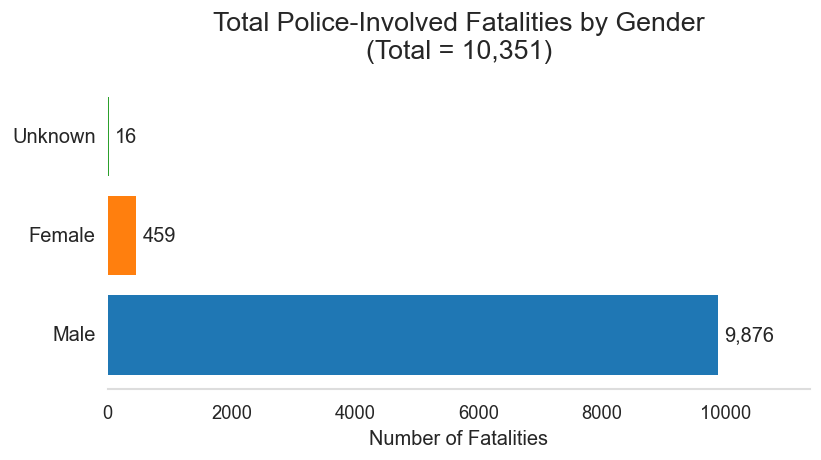

In [33]:
import matplotlib.pyplot as plt

# 1) Build the gender counts DataFrame
df_gender = (
    df_fatalities['gender']
      .fillna('Unknown')                     # fill any missing
      .value_counts()                         # count each category
      .reindex(['male','female','Unknown'],   # explicit order
               fill_value=0)                 # ensure all three appear
      .reset_index(name='count')              # turn into two‐col DF
      .rename(columns={'index':'gender'})     # rename index→gender
)

# 2) Compute the grand total for the title
total = int(df_gender['count'].sum())

# 3) Plot
fig, ax = plt.subplots(figsize=(7, 4), dpi=120)

bars = ax.barh(
    df_gender['gender'],
    df_gender['count'],
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # blue, orange, green
    edgecolor='none'
)

# 4) Annotate each bar with its count
max_count = df_gender['count'].max()
for bar in bars:
    w = bar.get_width()
    ax.text(
        w + max_count * 0.01,                   # a sliver to the right
        bar.get_y() + bar.get_height() / 2,     # vertical center
        f"{w:,}",                                # comma‐formatted
        va='center',
        fontsize=12
    )

# 5) Title, labels, and custom y‐labels
ax.set_title(
    f"Total Police-Involved Fatalities by Gender\n(Total = {total:,})",
    fontsize=16,
    pad=15
)
ax.set_xlabel("Number of Fatalities", fontsize=12)

# hide default y‐ticks and draw our own
ax.set_yticks([])
for i, gender in enumerate(df_gender['gender']):
    ax.text(
        -max_count * 0.02,                       # just left of the axis
        i,                                       # one line per bar
        gender.capitalize(),
        va='center',
        ha='right',
        fontsize=12
    )

# 6) Clean up spines & ticks
for spine in ['top','right','left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(left=False, bottom=False)

# 7) Expand x‐lim a bit so annotations never get cut off
ax.set_xlim(0, max_count * 1.15)

plt.tight_layout()
plt.show()





### 2.3.8 Age Distribution by Weapon Category and Gender (Box Plot)

We compare the **age distribution** of people killed by police across weapon categories, split by **gender**.

**Data prep**
- Keep the **top 6** `armed` categories; lump the rest into **“Other”**; fill unknowns as **“Unknown”**.
- Restrict comparison to **Male** vs **Female**; capitalize labels for readability.

**What the box plot shows**
- **Median line**, **IQR box**, and **whiskers** (±1.5×IQR); points outside are outliers.
- Each category (x-axis) shows the age distribution (y-axis) for both genders.

**Guiding questions**
- Do age distributions differ by **weapon category**?
- Are there systematic differences between **men** and **women** within categories?
- Which categories have **younger vs. older** median ages?

**Visualization:** Seaborn box plot (hue = gender), ordered by overall frequency of weapon categories.


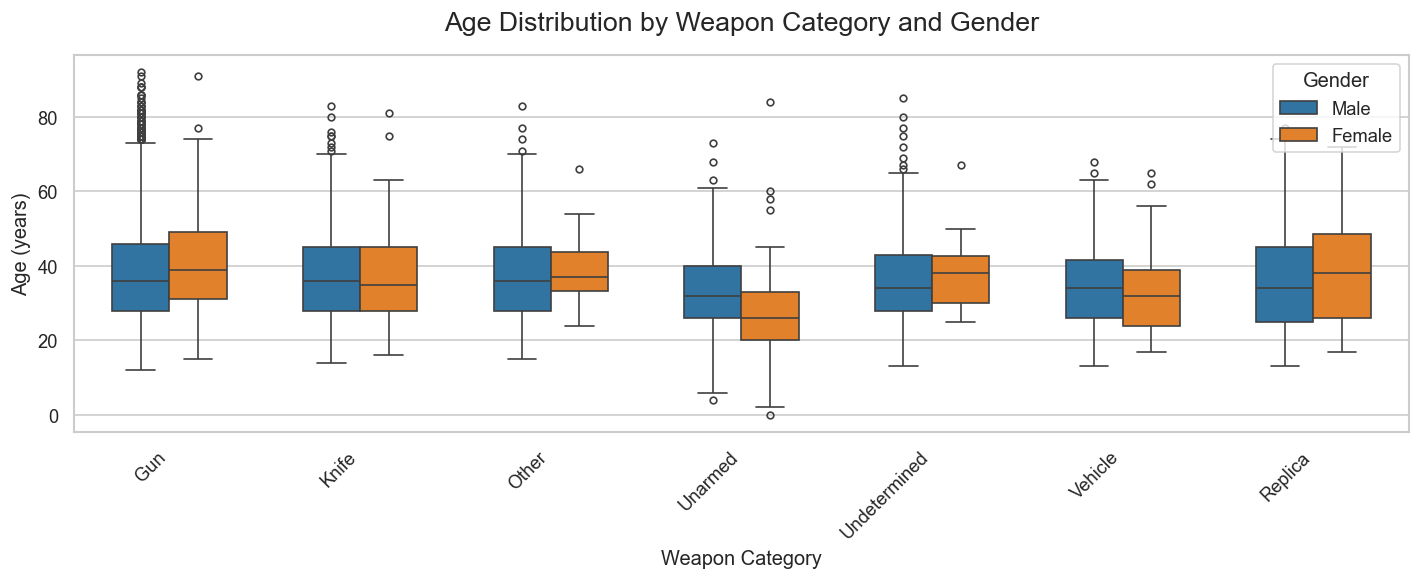

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Pick the top 6 armed categories + lump the rest into “Other”
top_armed = (
    df_fatalities['armed']
      .fillna('Unknown')
      .value_counts()
      .nlargest(6)
      .index
      .tolist()
)

def simplify(x):
    if pd.isna(x):
        return 'Unknown'
    return x if x in top_armed else 'Other'

# 2) Build a plotting DataFrame
df_plot = (
    df_fatalities
      .loc[df_fatalities['age'].notna(), ['age','gender','armed']]
      .assign(
          Age    = lambda d: d['age'],
          Gender = lambda d: d['gender'].fillna('Unknown').str.capitalize(),
          Manner = lambda d: d['armed'].fillna('Unknown').apply(simplify).str.capitalize()
      )
)

# 3) Order by overall frequency
order = df_plot['Manner'].value_counts().index.tolist()

# 4) Only compare Male vs. Female
palette = {'Male':'#1f77b4','Female':'#ff7f0e'}

# 5) Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,5), dpi=120)
ax = sns.boxplot(
    data=df_plot.query("Gender in ['Male','Female']"),
    x='Manner', y='Age',
    hue='Gender',
    order=order,
    palette=palette,
    whis=1.5, width=0.6, fliersize=4
)

ax.set_title("Age Distribution by Weapon Category and Gender", fontsize=16, pad=15)
ax.set_xlabel("Weapon Category", fontsize=12)
ax.set_ylabel("Age (years)", fontsize=12)
plt.xticks(rotation=45, ha="right")
ax.legend(title="Gender", loc="upper right")
plt.tight_layout()
plt.show()




### 2.3.9 Were People Armed?

Classify each case as **Gun**, **Unarmed**, or **Other** and summarize the distribution.

**Method**
- `armed` → map to three buckets:  
  - **Gun** if text contains “gun”  
  - **Unarmed** if null or explicitly “unarmed”  
  - **Other** otherwise
- Compute **counts** and **percentages** for each bucket.

**Guiding questions**
- What share of fatalities involved a **gun** vs. were **unarmed**?
- How large is the **Other** category?

**Visualizations**
- **Donut chart** of % by armed status (with total in the center).
- **Bar chart** of counts with % labels.

> *Note:* Text fields can be messy; this simplified mapping is transparent and reproducible but may group diverse weapons under **Other**.


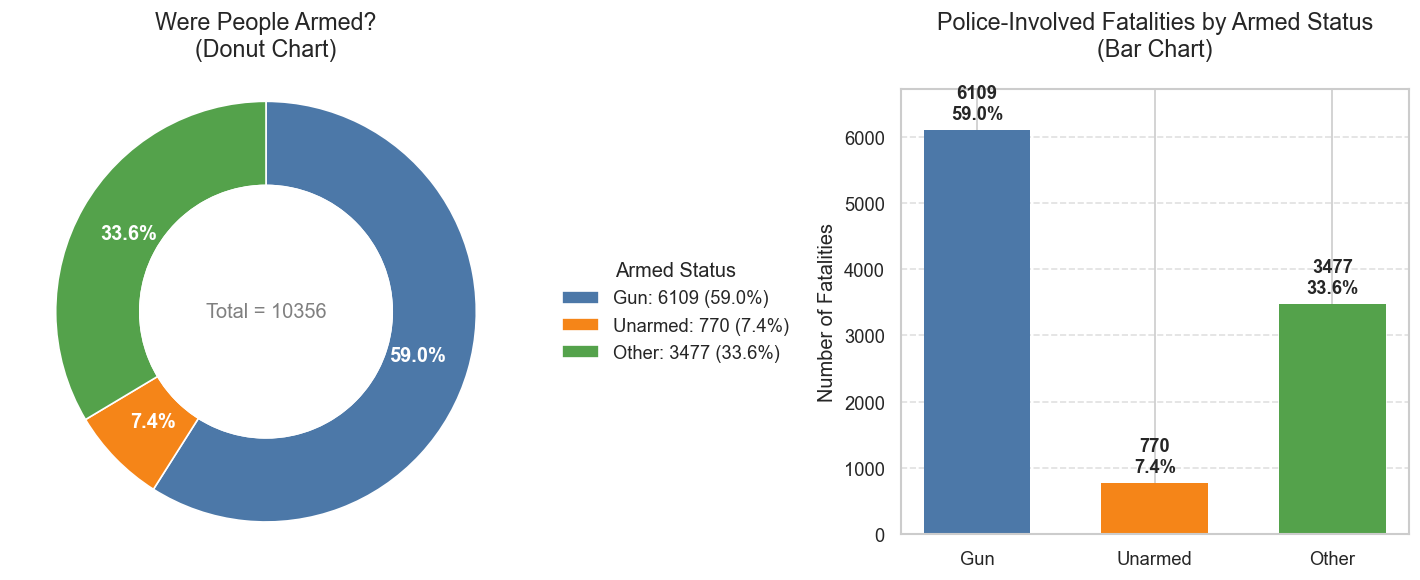

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Classify into Gun / Unarmed / Other
def classify_weapon(x):
    if pd.isna(x) or x.strip().lower() == 'unarmed':
        return 'Unarmed'
    if 'gun' in x.strip().lower():
        return 'Gun'
    return 'Other'

armed_cat = df_fatalities['armed'].fillna('Unarmed').map(classify_weapon)

# 2) Compute counts & pct
counts = armed_cat.value_counts().reindex(['Gun','Unarmed','Other'])
pcts   = (counts / counts.sum() * 100).round(1)
total  = counts.sum()

# 3) Start a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=120)

# ── Donut Chart ──────────────────────────────────────────────
def label_if_big(pct, allvals):
    return f"{pct:.1f}%" if pct >= 5 else ''

wedges, _, autotexts = ax1.pie(
    counts.values,
    labels=None,
    startangle=90,
    counterclock=False,
    colors=['#4C78A8','#F58518','#54A24B'],
    wedgeprops=dict(width=0.4, edgecolor='white'),
    autopct=lambda pct: label_if_big(pct, counts.values),
    pctdistance=0.75,
    textprops=dict(color='white', weight='bold', fontsize=12)
)
ax1.add_artist(plt.Circle((0,0), 0.6, fc='white'))
ax1.set_title("Were People Armed?\n(Donut Chart)", pad=20, fontsize=14)
ax1.axis('equal')

# Build legend labels with full info
legend_labels = [f"{k}: {counts[k]} ({pcts[k]:.1f}%)" for k in counts.index]
ax1.legend(wedges, legend_labels,
           title="Armed Status",
           loc="center left", bbox_to_anchor=(1.05, 0.5),
           frameon=False, fontsize=11)

# Center‐circle annotation
ax1.text(0, 0, f"Total = {total}", ha="center", va="center",
         fontsize=12, color="gray")


# ── Bar Chart ────────────────────────────────────────────────
bars = ax2.bar(
    counts.index,
    counts.values,
    color=['#4C78A8','#F58518','#54A24B'],
    edgecolor='none',
    width=0.6
)
# Annotate each bar with count & pct
for bar, cnt, pct in zip(bars, counts.values, pcts.values):
    ax2.text(
        bar.get_x() + bar.get_width()/2,
        cnt + total*0.01,     # a little above
        f"{cnt}\n{pct:.1f}%",
        ha='center', va='bottom',
        fontsize=11, weight='bold'
    )

ax2.set_title("Police-Involved Fatalities by Armed Status\n(Bar Chart)", pad=20, fontsize=14)
ax2.set_ylabel("Number of Fatalities", fontsize=12)
ax2.set_ylim(0, counts.max()*1.1)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## 2.3.10 How Old Were the People Killed?

In this section, we examine the overall **age distribution** of individuals killed in police-involved incidents.  
Our goals are:

- Plot the distribution of ages (using a histogram with a KDE overlay).  
- Report the **mean, median, and age range**.  
- Compute the **percentage of victims under 25 years old**.  

This helps us understand whether police-involved fatalities are more concentrated among younger or older populations.


Work out what percentage of people killed were under 25 years old.  

In [36]:
# 1) Drop any rows without an age
valid_ages = df_fatalities['age'].dropna()

# 2) Compute total and under-25 counts
total = len(valid_ages)
under_25 = (valid_ages < 25).sum()

# 3) Compute percentage
pct_under_25 = under_25 / total * 100

print(f"Of the {total:,} cases with a known age, {under_25:,} ({pct_under_25:.1f}%) were under 25 years old.")


Of the 9,992 cases with a known age, 1,515 (15.2%) were under 25 years old.


Create a histogram and KDE plot that shows the distribution of ages of the people killed by police. 

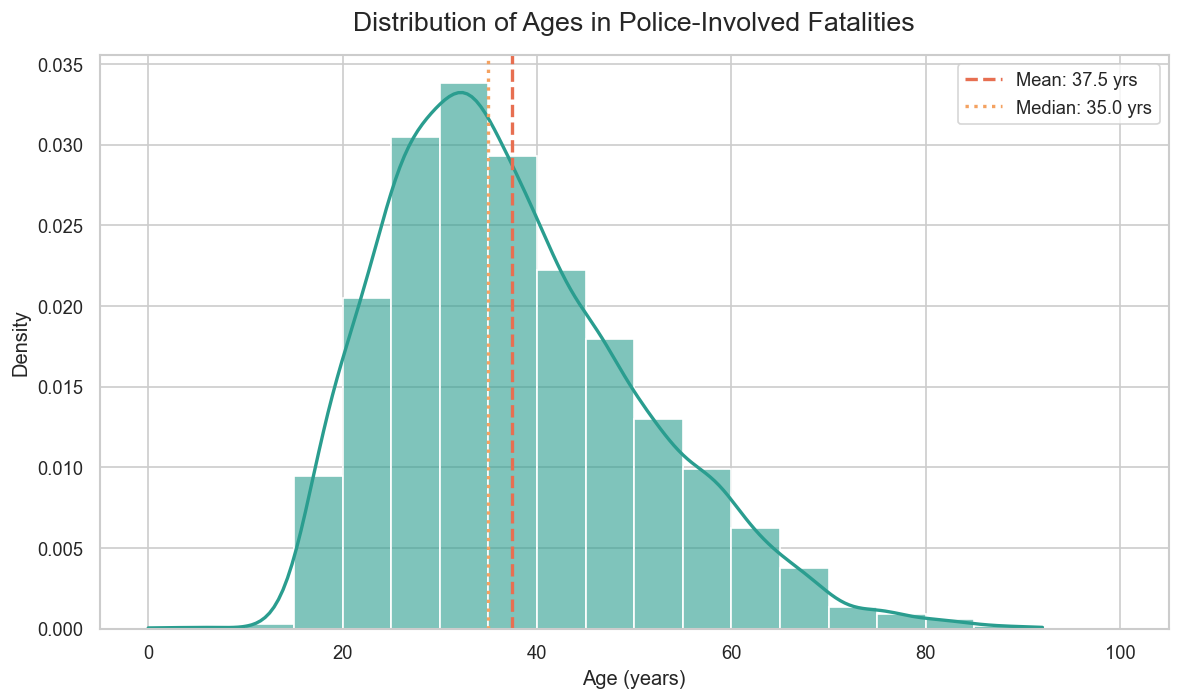

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Drop missing ages
ages = df_fatalities['age'].dropna()

# 2) Build the figure
plt.figure(figsize=(10, 6), dpi=120)
sns.set_theme(style="whitegrid")

# 3) Plot histogram + KDE
sns.histplot(
    ages,
    bins=range(0, 101, 5),     # 5-year bins
    stat="density",            # so hist & KDE share the same vertical scale
    color="#2a9d8f",
    alpha=0.6,
    edgecolor="w",
    kde=True,
    line_kws=dict(color="#264653", linewidth=2)  # styling for the KDE line
)

# 4) Add mean/median lines
mean_age = ages.mean()
med_age  = ages.median()
plt.axvline(mean_age, color="#e76f51", linestyle="--", linewidth=2,
            label=f"Mean: {mean_age:.1f} yrs")
plt.axvline(med_age,  color="#f4a261", linestyle=":",  linewidth=2,
            label=f"Median: {med_age:.1f} yrs")

# 5) Labels, legend & layout
plt.title("Distribution of Ages in Police-Involved Fatalities", fontsize=16, pad=15)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Density",      fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()



## 2.3.11 How Does Age Distribution Differ by Race?

While 2.3.10 looked at all victims combined, here we disaggregate by **race**.  
Using **Kernel Density Estimates (KDEs)** for each racial group, we compare how the ages of those killed vary across populations.  

This highlights whether certain groups show younger or older age profiles relative to others.


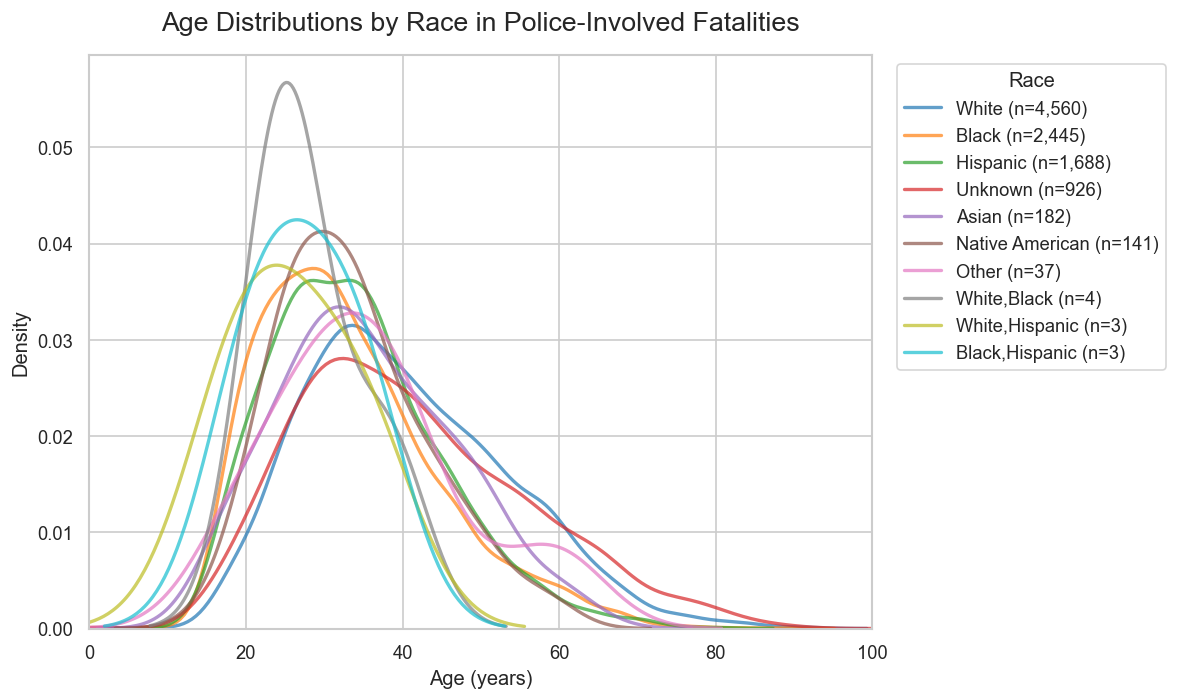

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Prepare data, fill missing races & drop missing ages
df = df_fatalities.copy()
df['race'] = df['race'].fillna('Unknown')
df = df[df['age'].notna()]

# 2) Build ordered list of races by frequency
races = df['race'].value_counts().index.tolist()
palette = sns.color_palette("tab10", n_colors=len(races))

# 3) Plot one KDE per race, suppress singular warnings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6), dpi=120)

for race, color in zip(races, palette):
    ages = df.loc[df['race'] == race, 'age']
    sns.kdeplot(
        ages,
        fill=False,
        common_norm=False,
        label=f"{race} (n={len(ages):,})",
        linewidth=2,
        alpha=0.7,
        color=color,
        bw_adjust=1.0,
        warn_singular=False      # <— suppress zero‐variance warnings
    )

# 4) Tidy up
plt.title("Age Distributions by Race in Police-Involved Fatalities", fontsize=16, pad=15)
plt.xlabel("Age (years)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Race", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xlim(0,100)
plt.tight_layout()
plt.show()



## 2.3.12 Race of People Killed

In this step, we explore the **racial distribution** of people killed in police-involved incidents.  

- We count the total number of fatalities for each racial group.  
- Missing values are categorized as **"Unknown"**.  
- The results are shown in a bar chart, with the count of fatalities displayed above each bar.  

This visualization helps us understand which racial groups are most represented in the dataset and provides a foundation for later analyses on racial disparities.


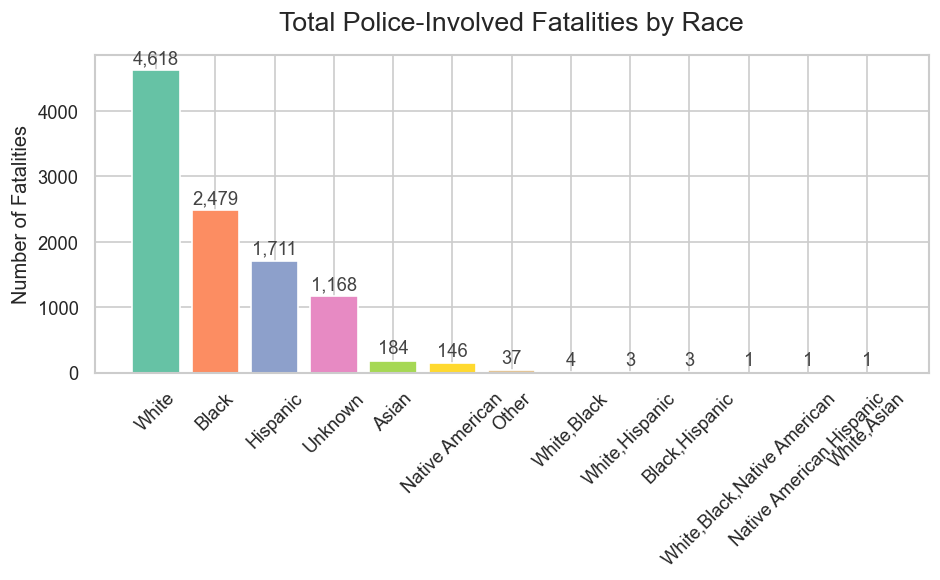

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Count people killed by race
race_counts = (
    df_fatalities['race']
      .fillna('Unknown')
      .value_counts()
      .rename_axis('Race')
      .reset_index(name='Count')
)

# 2) Sort descending
race_counts = race_counts.sort_values('Count', ascending=False)

# 3) Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

bars = ax.bar(
    race_counts['Race'],
    race_counts['Count'],
    color=plt.cm.Set2.colors[:len(race_counts)],
    edgecolor='white'
)

# 4) Annotate counts above bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(race_counts['Count']) * 0.01,
        f"{height:,}",
        ha='center',
        va='bottom',
        fontsize=11,
        color='#444'
    )

# 5) Formatting
ax.set_title("Total Police-Involved Fatalities by Race", fontsize=16, pad=15)
ax.set_xlabel("")  # race is obvious on x-axis
ax.set_ylabel("Number of Fatalities", fontsize=12)
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()


## 2.3.13 Mental Illness and Police Killings

In this section, we investigate the role of **mental illness** in police-involved fatalities.  

- The dataset contains an indicator field `signs_of_mental_illness` which captures whether the person killed was reported to have shown signs of mental illness.  
- We categorize the cases into **Yes**, **No**, and **Unknown**.  
- Both the **absolute number of fatalities** and their **percentages** are displayed in the chart.  

This visualization provides insight into how frequently mental illness is reported among people killed by police, highlighting its potential significance in fatal encounters.


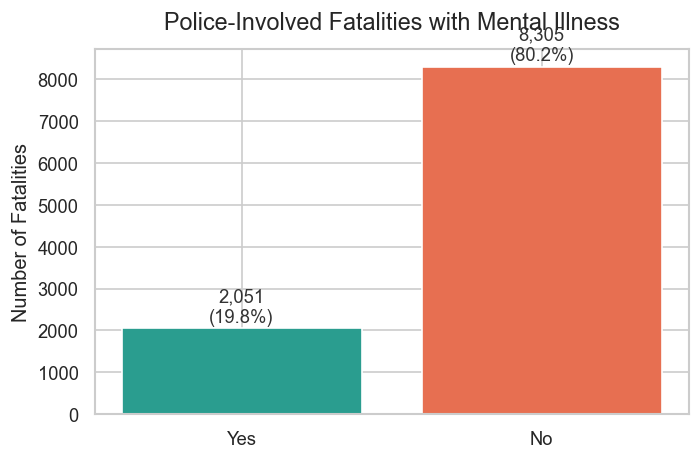

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Prepare the data using the correct column name
mi = (
    df_fatalities['signs_of_mental_illness']     # ← correct field
      .fillna('Unknown')                         # fill NaNs
      .replace({True: 'Yes', False: 'No'})       # map bool→string
      .value_counts()
      .rename_axis('Mental Illness')
      .reset_index(name='Count')
)

# 2) Compute total & percentages
total = mi['Count'].sum()
mi['Pct'] = (mi['Count'] / total * 100).round(1)

# 3) Force the order Yes→No→Unknown
order = ['Yes','No','Unknown']
mi['Mental Illness'] = pd.Categorical(mi['Mental Illness'], categories=order, ordered=True)
mi = mi.sort_values('Mental Illness')

# 4) Plot
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
colors = ['#2a9d8f','#e76f51','#264653']

bars = ax.bar(mi['Mental Illness'], mi['Count'], color=colors)

# Annotate counts and percentages
for bar, pct in zip(bars, mi['Pct']):
    y = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        y + total * 0.005,
        f"{int(y):,}\n({pct}%)",
        ha='center', va='bottom', fontsize=11, color='#333'
    )

# Labels & title
ax.set_title("Police-Involved Fatalities with Mental Illness", fontsize=14, pad=12)
ax.set_ylabel("Number of Fatalities", fontsize=12)
ax.set_xlabel("")
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
plt.tight_layout()
plt.show()



## 2.3.14 In Which Cities Do the Most Police Killings Take Place?

This section identifies the **top 10 U.S. cities** with the highest number of police-involved fatalities.  

- We aggregate the data by the `city` column to count the total number of deaths per city.  
- Missing values are categorized as *Unknown*.  
- The results are displayed in a **horizontal bar chart**, with the most dangerous cities ranked at the top.  

This visualization highlights the cities with the greatest concentration of police-involved fatalities, providing insight into potential regional patterns and areas of concern.
 

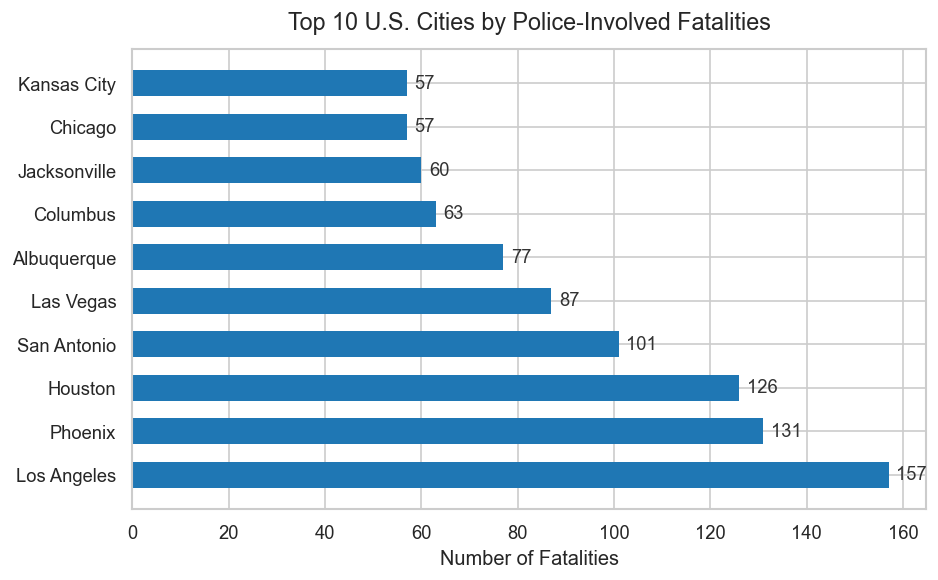

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Count fatalities by city (fill missing)
city_counts = (
    df_fatalities['city']
      .fillna('Unknown')
      .value_counts()
)

# 2) Take top 10
top10 = city_counts.head(10)
cities = top10.index.tolist()
counts = top10.values.tolist()

# 3) Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

bars = ax.barh(
    y=cities[::-1],         # reverse for largest at top
    width=counts[::-1],
    color='#1f77b4',
    edgecolor='none',
    height=0.6
)

# 4) Annotate counts
for bar in bars:
    w = bar.get_width()
    ax.text(
        w + max(counts)*0.01,           # a little to the right
        bar.get_y() + bar.get_height()/2,
        f"{int(w):,}",                  # formatted with commas
        va='center',
        fontsize=11,
        color='#333'
    )

# 5) Labels & title
ax.set_title("Top 10 U.S. Cities by Police-Involved Fatalities", fontsize=14, pad=12)
ax.set_xlabel("Number of Fatalities", fontsize=12)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.invert_yaxis()  # highest on top

plt.tight_layout()
plt.show()


## 2.3.15 Rate of Death by Race  

In this section, we examine the **racial breakdown of police-involved fatalities** in the top 10 cities with the highest number of deaths.  

- First, we identify the 10 cities with the most fatalities.  
- For each city, we count how many victims belong to each racial group.  
- We then calculate the **percentage share of fatalities by race**, relative to the city’s total.  
- The results are visualized using a **stacked horizontal bar chart**, where each city’s bar sums to 100%.  

This allows us to contrast how racial disparities manifest across different cities, highlighting whether certain groups are disproportionately affected.


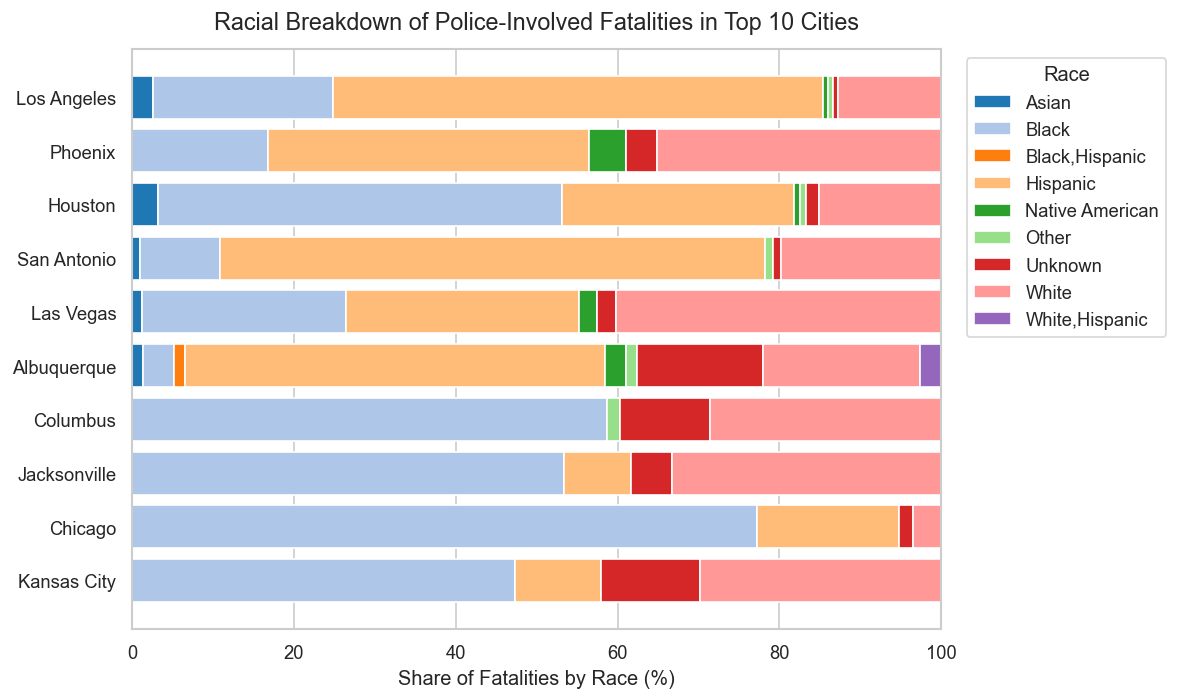

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Identify the top 10 cities by number of fatalities
top10_cities = (
    df_fatalities['city']
      .fillna('Unknown')
      .value_counts()
      .head(10)
      .index
      .tolist()
)

# 2) Build a city × race table of counts
city_race_counts = (
    df_fatalities
      .assign(city=lambda d: d['city'].fillna('Unknown'),
              race=lambda d: d['race'].fillna('Unknown'))
      .loc[lambda d: d['city'].isin(top10_cities)]
      .groupby(['city','race'])
      .size()
      .unstack(fill_value=0)
      .loc[top10_cities]        # ensure the same order
)

# 3) Convert counts to percentages (by city)
city_race_pct = city_race_counts.div(city_race_counts.sum(axis=1), axis=0) * 100

# 4) Plot — a stacked bar for each city
fig, ax = plt.subplots(figsize=(10, 6), dpi=120)

bottom = pd.Series(0, index=top10_cities)
colors = plt.cm.tab20.colors  # up to 20 distinct colors

for i, race in enumerate(city_race_pct.columns):
    ax.barh(
        y=top10_cities,
        width=city_race_pct[race],
        left=bottom,
        label=race,
        color=colors[i]
    )
    bottom += city_race_pct[race]

# 5) Formatting
ax.set_xlabel("Share of Fatalities by Race (%)", fontsize=12)
ax.set_title("Racial Breakdown of Police-Involved Fatalities in Top 10 Cities", fontsize=14, pad=12)
ax.invert_yaxis()  # highest-count city at top
ax.set_xlim(0, 100)
ax.legend(title="Race", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## 2.3.16 Choropleth: Police‑Involved Fatalities by U.S. State

We map the **count of fatalities** by state to see where police‑involved deaths are most concentrated.

**Steps**
1. Aggregate fatalities by the `state` field (2‑letter USPS codes).
2. Drop `"Unknown"` entries to keep the map clean.
3. Render a **U.S. choropleth** (Plotly) with a **Reds** scale; darker = more fatalities.

**Guiding questions**
- Which states show the **highest totals**?
- Do these states overlap with those that have **higher poverty** or **lower HS completion** from earlier sections?
- Are there **regional clusters** (e.g., West vs. South vs. Midwest)?

**Notes**
- If your `state` values are full names, convert to USPS codes before mapping.
- Counts are raw totals; for fair comparisons, consider adding a **rate per 100k population** in a follow‑up map.

**Visualization:** Plotly choropleth of fatalities by state.


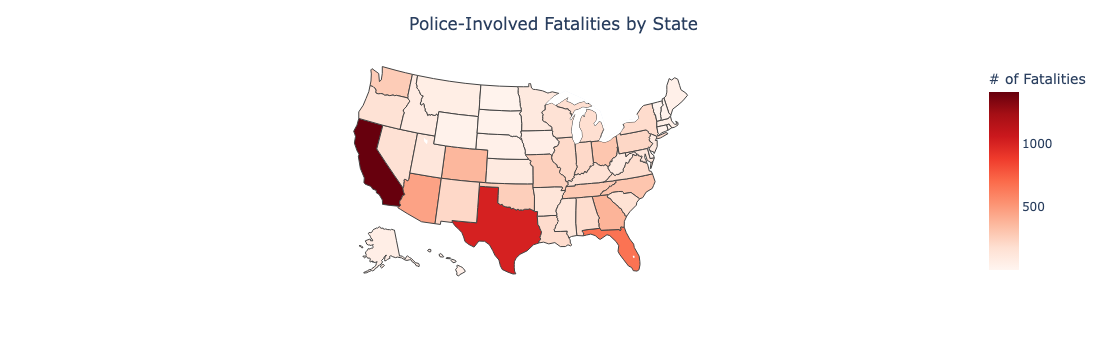

In [43]:
import pandas as pd
import plotly.express as px

# 1) Count fatalities by state (fill missing as “Unknown” if needed)
state_counts = (
    df_fatalities['state']
      .fillna('Unknown')
      .value_counts()
      .rename_axis('state')
      .reset_index(name='fatalities')
)

# 2) Filter out “Unknown” and ensure we have the standard 2-letter codes
#    If your `state` column already uses 2-letter USPS codes (e.g. 'CA','NY'), you’re set.
#    Otherwise you may need a lookup to convert full names → USPS codes.
state_counts = state_counts[state_counts['state'] != 'Unknown'].copy()

# 3) Draw the map
fig = px.choropleth(
    state_counts,
    locations='state',            # column with 2-letter state codes
    locationmode='USA-states',    # tells Plotly these are US states
    color='fatalities',           
    color_continuous_scale='Reds',
    scope='usa',
    labels={'fatalities':'# of Fatalities'},
    hover_data=['fatalities'],
)

fig.update_layout(
    title_text = 'Police-Involved Fatalities by State',
    title_x = 0.5,
    geo = dict(
        lakecolor='white',
        bgcolor='rgba(0,0,0,0)'
    )
)

fig.show()


## 2.3.17 Police Killings Over Time

We examine the **temporal trend** of police-involved fatalities from 2015–2024.

**Steps**
1. Parse the `date` column from the Fatal Force dataset (`mm/dd/yy` format).  
2. Convert to monthly periods (`dt.to_period('M')`) and count fatalities per month.  
3. Line plot with markers to show monthly fluctuations.

**Insights to Explore**
- Are killings **steady**, **increasing**, or **decreasing** year-to-year?  
- Look for **seasonality** (e.g., summer peaks).  
- Identify **spikes** or **outliers** that may align with major events or policy changes.  

**Follow-up Questions**
- Do downward trends reflect **policy reforms** or **data reporting changes**?  
- Should we also compare with **population-adjusted rates** rather than raw counts?  

**Visualization:** Time-series line chart of monthly fatalities, 2015–2024.


In [48]:
print(df_fatalities.columns)
print(df_fatalities['date'].head(10))
print(df_fatalities['date'].dtype)


Index(['date', 'name', 'age', 'gender', 'armed', 'race', 'city', 'state',
       'flee', 'body_camera', 'signs_of_mental_illness',
       'police_departments_involved', 'month'],
      dtype='object')
Series([], Name: date, dtype: datetime64[ns])
datetime64[ns]


In [49]:
# right after you read in df_fatalities
print(df_fatalities.columns)            # make sure the column really is named "date"
print(df_fatalities['date'].head(10))   # show the first 10 raw strings
print(df_fatalities['date'].dtype)      # should be object


Index(['date', 'name', 'age', 'gender', 'armed', 'race', 'city', 'state',
       'flee', 'body_camera', 'signs_of_mental_illness',
       'police_departments_involved', 'month'],
      dtype='object')
Series([], Name: date, dtype: datetime64[ns])
datetime64[ns]


month
2015-01-01    76
2015-02-01    77
2015-03-01    92
2015-04-01    84
2015-05-01    72
Name: fatalities, dtype: int64 

count   120.00
mean     86.92
std      12.02
min      59.00
25%      78.00
50%      87.00
75%      94.00
max     126.00
Name: fatalities, dtype: float64 



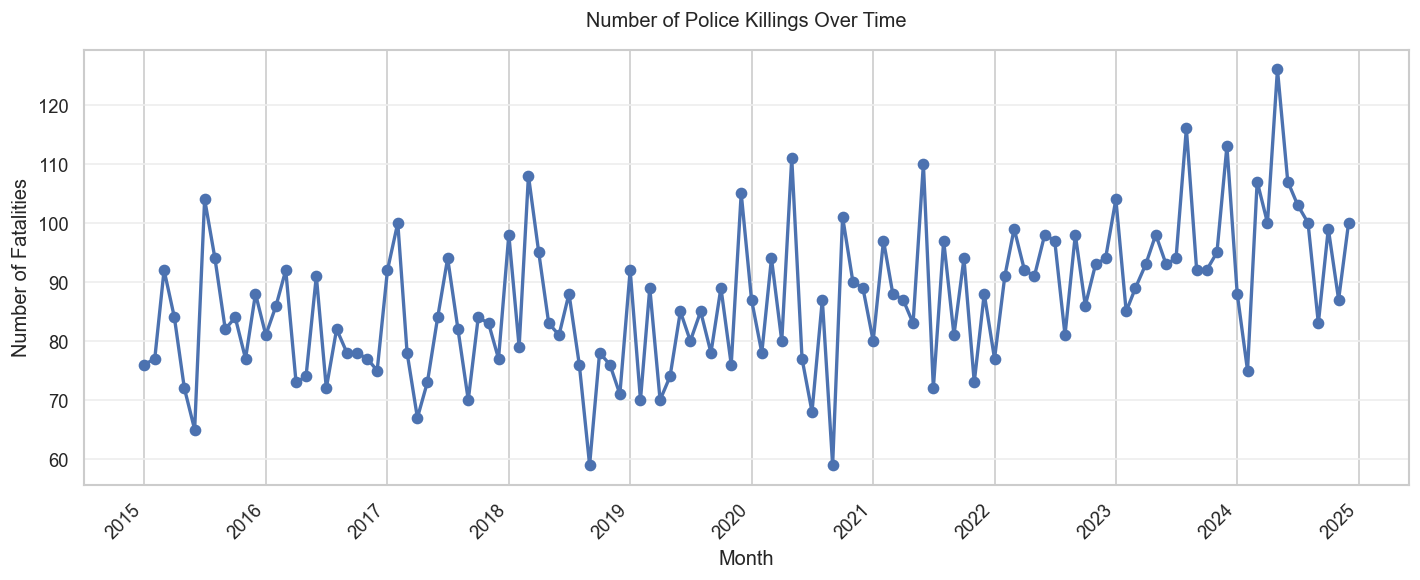

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load raw Fatal Force data
file_path = '/Users/puru/Desktop/Fatal +Force+Start /Census Data Collection and API files/Deaths_by_Police_US 15-2024.csv'
df = pd.read_csv(file_path, encoding='latin1')

# 2) Parse with explicit format to avoid the warning
df['date'] = pd.to_datetime(
    df['date'],
    format='%m/%d/%y',   # month/day/2-digit year
    errors='coerce'
)
df.dropna(subset=['date'], inplace=True)

# 3) Build monthly counts
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('month').size().rename('fatalities')

# 4) Quick sanity check
print(monthly.head(), '\n')
print(monthly.describe(), '\n')

# 5) Plot
plt.figure(figsize=(12,5), dpi=120)
plt.plot(monthly.index, monthly.values, marker='o', linewidth=2)
plt.title('Number of Police Killings Over Time', pad=14)
plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
plt.grid(axis='y', color='#EEEEEE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()







# Epilogue

Now that you have analysed the data yourself, read [The Washington Post's analysis here](https://www.washingtonpost.com/graphics/investigations/police-shootings-database/).